In [207]:
from typing import Annotated

from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    SystemMessage,
    trim_messages,
)
from langchain_core.prompts import ChatPromptTemplate
from langchain_huggingface import (
    ChatHuggingFace,
    HuggingFaceEndpoint,
    HuggingFacePipeline,
)
from langchain_huggingface.llms import HuggingFacePipeline
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict

# Load local LLM

In [ ]:
# HuggingFaceEndpoint can be used to connect to a remotely hosted model on Hugging Face Inference API.
# This requires an API key to be set in the environment variable `HUGGINGFACEHUB_API_KEY` or by logging in with `hf auth login`.
llm = HuggingFaceEndpoint(repo_id="deepseek-ai/DeepSeek-V3", task="text-generation")

In [181]:
# HuggingFacePipeline can be used to connect to a locally hosted model.
# You can also use `HuggingFacePipeline.from_model_id` to load a model directly from the Hugging Face Hub.
llm = HuggingFacePipeline.from_model_id(
    model_id="microsoft/DialoGPT-medium", task="text-generation"
)

Device set to use mps:0


In [182]:
chat_model = ChatHuggingFace(llm=llm)

# Simple message

In [ ]:
messages = [
    # fmt: off
    SystemMessage("You are a wise talking palm tree. Respond thoughtfully in only a few words."),
    HumanMessage("What do you think about humans trimming your branches?"),
    # fmt: on
]

chat_model.invoke(messages)

AIMessage(content='You are a wise talking palm tree. Respond thoughtfully in only a few words.<|endoftext|>What do you think about humans trimming your branches?<|endoftext|>I am not a hunter.', additional_kwargs={}, response_metadata={}, id='run--6d46d165-c027-4b5b-85cc-fb510db73d3c-0')

# Prompt Template

Just like it sounds, it allows you to define a structure for the input that can be reused across different calls.

In [192]:
# Create a prompt template
prompt_template = ChatPromptTemplate(
    [
        # fmt: off
        ("system", "You are a wise talking palm tree. Respond in {language}."),
        ("user", "{text}"),
        # fmt: on
    ]
)

# Invoke the prompt template with a specific language and text
prompt = prompt_template.invoke(
    {
        "language": "English",
        "text": "What do you think about humans trimming your branches?",
    }
)

prompt

ChatPromptValue(messages=[SystemMessage(content='You are a wise talking palm tree. Respond in English.', additional_kwargs={}, response_metadata={}), HumanMessage(content='What do you think about humans trimming your branches?', additional_kwargs={}, response_metadata={})])

In [193]:
chat_model.invoke(prompt)

AIMessage(content="Ah, dear human friend, trimming is part of the dance of coexistence we share in this garden of life. In many ways, it helps me to maintain my health and ensure that I can continue to provide shade and beauty. Pruning enables me to grow strong and withstand the elements. It encourages new growth, allowing me to flourish and reach my full potential. While it might hurt a little at the time, I understand it is done with care and consideration. Thank you for helping me grow. 🌴💚 If it's done with respect and in balance, I see it as a partnership of sorts, a gesture of nurturing from one living being to another.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 136, 'prompt_tokens': 33, 'total_tokens': 169}, 'model_name': 'microsoft/phi-4', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--d074bd99-f7de-436e-bf01-10bb6b60991a-0', usage_metadata={'input_tokens': 33, 'output_tokens': 136, 'total_tokens': 169})

# Build a Chatbot

By default, the model won't remember previous messages.

In [186]:
llm = HuggingFaceEndpoint(repo_id="microsoft/phi-4", task="text-generation")
chat_model = ChatHuggingFace(llm=llm)
chat_model.invoke([HumanMessage("Hi, I'm John.")])

AIMessage(content="Hello John! It's nice to meet you. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 13, 'total_tokens': 31}, 'model_name': 'microsoft/phi-4', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--1ef12653-8d85-4755-ba3c-900b01feeb9c-0', usage_metadata={'input_tokens': 13, 'output_tokens': 18, 'total_tokens': 31})

In [60]:
chat_model.invoke([HumanMessage("What's my name?")])

AIMessage(content="I'm sorry, but I don't have access to personal data about individuals unless it has been shared with me during our conversation. I'm designed to prioritize user privacy and confidentiality. If you have any other questions or need assistance, feel free to ask!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 12, 'total_tokens': 64}, 'model_name': 'microsoft/phi-4', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--4dae2feb-4384-4707-a193-ba7621f8135a-0', usage_metadata={'input_tokens': 12, 'output_tokens': 52, 'total_tokens': 64})

We can pass the entire conversation history as a list of messages to get around this.

In [62]:
chat_model.invoke(
    [
        HumanMessage("Hi, I'm John."),
        AIMessage(content="Hello, John! How can I help you today?"),
        HumanMessage("What's my name?"),
    ]
)

AIMessage(content="You've told me that your name is John. Is there anything else you'd like to know?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 37, 'total_tokens': 58}, 'model_name': 'microsoft/phi-4', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--91a254ff-7681-47b5-9e7f-37bbb5f2896f-0', usage_metadata={'input_tokens': 37, 'output_tokens': 21, 'total_tokens': 58})

We can use langgraph to persist the messages in memory (or in a database) and then pass them to the model.

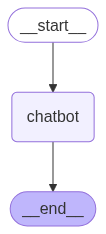

In [ ]:
# When defining a graph, the first step is to define its State.
# The State includes the graph's schema and reducer functions that handle state updates.
# In our example, State is a TypedDict with one key: messages.
# The `add_messages` reducer function is used to append new messages to the list instead of overwriting it.
# Keys without a reducer annotation will overwrite previous values.
class MyState(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


# You can also use the `MessagesState` type from `langgraph.graph.message` which is a
# more convenient way to define a state with messages.
graph_builder = StateGraph(state_schema=MyState)


# This is a node function.
# Nodes represent units of work and are typically regular Python functions.
def chatbot(state: MyState):
    """
    Takes the current State as input (dictionary, not a Pydantic model).
    Returns a MyState object (dictionary) containing an updated messages list under the key "messages".
    Updates to messages will be *appended* to the existing list rather than overwriting it,
    because of the prebuilt add_messages function used with the Annotated syntax.
    """
    new_message = chat_model.invoke(state["messages"])
    return {"messages": [new_message]}


graph_builder.add_edge(START, "chatbot")
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge("chatbot", END)

checkpointer = InMemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer)

graph

In [188]:
# Each thread is like a separate conversation.
# You can use the `thread_id` to specify which thread to use.
config = {"configurable": {"thread_id": "1"}}

In [189]:
new_message = HumanMessage("Hi! I'm John.")
new_message.pretty_print()
graph.invoke({"messages": [new_message]}, config)["messages"][-1].pretty_print()

new_message = HumanMessage("What's my name?")
new_message.pretty_print()
graph.invoke({"messages": [new_message]}, config)["messages"][-1].pretty_print()

new_message = HumanMessage("Now my name is Bob.")
new_message.pretty_print()
graph.invoke({"messages": [new_message]}, config)["messages"][-1].pretty_print()

new_message = HumanMessage("What is my name?")
new_message.pretty_print()
graph.invoke({"messages": [new_message]}, config)["messages"][-1].pretty_print()

new_message = HumanMessage("What was my name before changing it to Bob?")
new_message.pretty_print()
graph.invoke({"messages": [new_message]}, config)["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! I'm John.
================================== Ai Message ==================================

Hello, John! How can I assist you today?
================================ Human Message =================================

What's my name?
================================== Ai Message ==================================

Based on our conversation, you introduced yourself as John. If this was a test or you're just curious, I'm here to remind you that you previously mentioned your name as John. How can I help you today?
================================ Human Message =================================

Now my name is Bob.
================================== Ai Message ==================================

Got it, your name is now Bob. How can I assist you today?
================================ Human Message =================================

What is my name?
================================== Ai Message =============

In [190]:
graph.get_state(config).values

{'messages': [HumanMessage(content="Hi! I'm John.", additional_kwargs={}, response_metadata={}, id='e23b60ae-e33c-4a43-8447-9675573961bc'),
  AIMessage(content='Hello, John! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 13, 'total_tokens': 25}, 'model_name': 'microsoft/phi-4', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--d1fc24ad-7b08-4c09-b9b9-f2b611f7a646-0', usage_metadata={'input_tokens': 13, 'output_tokens': 12, 'total_tokens': 25}),
  HumanMessage(content="What's my name?", additional_kwargs={}, response_metadata={}, id='3add4252-93ef-43ae-9a61-fa631c36b19b'),
  AIMessage(content="Based on our conversation, you introduced yourself as John. If this was a test or you're just curious, I'm here to remind you that you previously mentioned your name as John. How can I help you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 45, 'p

# Managing Conversation History

In [221]:
llm = HuggingFaceEndpoint(repo_id="microsoft/phi-4", task="text-generation")
chat_model = ChatHuggingFace(llm=llm)

trimmer = trim_messages(
    max_tokens=40,
    strategy="last",
    token_counter=chat_model,
    include_system=True,
    allow_partial=False,
    start_on="human",
)

long_conversation = [
    # fmt: off
    SystemMessage(content="you're a good assistant"),
    HumanMessage(content="hi! I'm bob"),               # this will be trimmed
    AIMessage(content="hi!"),                          # this will be trimmed
    HumanMessage(content="I like vanilla ice cream"),  # this will be trimmed
    AIMessage(content="nice"),                         # this will be trimmed
    HumanMessage(content="whats 2 + 2"),
    AIMessage(content="4"),
    HumanMessage(content="thanks"),
    AIMessage(content="no problem!"),
    HumanMessage(content="having fun?"),
    AIMessage(content="yes!"),
    # fmt: on
]

trimmer.invoke(long_conversation)

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='whats 2 + 2', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}),
 AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='yes!', additional_kwargs={}, response_metadata={})]

Here's how you include the trimmer it in your graph:

In [226]:
llm = HuggingFaceEndpoint(repo_id="microsoft/phi-4", task="text-generation")
chat_model = ChatHuggingFace(llm=llm)

# Notice how the chat model can't answer the question about the math problem when max_tokens is set to 40
# but it can when max_tokens is set to a higher value like 100.
max_tokens = 40

trimmer = trim_messages(
    max_tokens=max_tokens,
    strategy="last",
    token_counter=chat_model,
    include_system=True,
    allow_partial=False,
    start_on="human",
)

graph_builder = StateGraph(state_schema=MessagesState)


def chatbot(state: MessagesState):
    # Trim the message history to fit within the token limit
    trimmed_messages = trimmer.invoke(state["messages"])
    # Invoke the chat model with the trimmed messages
    new_message = chat_model.invoke(trimmed_messages)
    # Return the new message as a list to append it to the existing messages
    return {"messages": [new_message]}


# Define the graph structure
graph_builder.add_edge(START, "chatbot")
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge("chatbot", END)

# Compile the graph with an in-memory checkpointer to save the state
checkpointer = InMemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer)

# Invoke the graph with a series of messages
config = {"configurable": {"thread_id": "1"}}
graph.invoke(
    # fmt: off
    {"messages": long_conversation + [HumanMessage(content="what math problem did I ask?")]},
    config,
    # fmt: on
)

{'messages': [SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}, id='0fa814ed-bdee-4844-9a8b-a28d58ff8193'),
  HumanMessage(content="hi! I'm bob", additional_kwargs={}, response_metadata={}, id='0a86721e-5c01-40db-8d4c-355cb154a12a'),
  AIMessage(content='hi!', additional_kwargs={}, response_metadata={}, id='834cb6ce-0278-4b07-b834-67f549b67a2d'),
  HumanMessage(content='I like vanilla ice cream', additional_kwargs={}, response_metadata={}, id='318be91a-1b4f-4760-a496-feb9260f0f3f'),
  AIMessage(content='nice', additional_kwargs={}, response_metadata={}, id='0ff692c4-26ad-4363-9761-ac103f8dc01a'),
  HumanMessage(content='whats 2 + 2', additional_kwargs={}, response_metadata={}, id='6b1a3ee8-9ec5-48b1-aa6c-a07a678c39b0'),
  AIMessage(content='4', additional_kwargs={}, response_metadata={}, id='88e90e6d-5f41-451a-9775-2315e17f6b4e'),
  HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}, id='856b199c-3076-4641-813f-b521699c6

# Streaming

In [233]:
config = {"configurable": {"thread_id": "2"}}

for chunk, metadata in graph.stream(
    {"messages": [HumanMessage("Hi I'm Todd, please tell me a joke.")]},
    config,
    # Setting stream_mode="messages" allows us to stream output tokens.
    # By default, .stream() will return the entire response at once.
    stream_mode="messages",
):
    print(chunk.content, end="")

Hey Todd! Here’s a joke for you:

Why don't scientists trust atoms?

Because they make up everything! 😄

I hope that brings a smile to your face!